<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# Basic PyTorch Neural Network
Now it's time to put the pieces together. In this section we'll:
* create a multi-layer deep learning model
* load data
* train and validate the model<br>

We'll also introduce a new step:
* save and load a trained model

Our goal is to develop a model capable of classifying an iris plant based on four features. This is a multi-class classification where each sample can belong to ONE of 3 classes (<em>Iris setosa</em>, <em>Iris virginica</em> or <em>Iris versicolor</em>). The network will have 4 input neurons (flower dimensions) and 3 output neurons (scores). Our loss function will compare the target label (ground truth) to the corresponding output score. 

<div class="alert alert-info"><strong>NOTE:</strong> Multi-class classifications usually involve converting the target vector to a one_hot encoded matrix. That is, if 5 labels show up as<br>
<pre style='background-color:rgb(217,237,247)'>tensor([0,2,1,0,1])</pre>
then we would encode them as:
<pre style='background-color:rgb(217,237,247)'>tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]])</pre>
This is easily accomplished with <a href='https://pytorch.org/docs/stable/nn.html#one-hot'><strong><tt>torch.nn.functional.one_hot()</tt></strong></a>.<br>
However, our loss function <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a> takes care of this for us.</div>

## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Create a model class
For this exercise we're using the Iris dataset. Since a single straight line can't classify three flowers we should include at least one hidden layer in our model.

In the forward section we'll use the <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>rectified linear unit</a> (ReLU)  function<br>
$\quad f(x)=max(0,x)$<br>
as our activation function. This is available as a full module <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong><tt>torch.nn.ReLU</tt></strong></a> or as just a functional call <a href='https://pytorch.org/docs/stable/nn.html#id27'><strong><tt>torch.nn.functional.relu</tt></strong></a>

In [2]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [3]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
model = Model()

## Load the iris dataset

In [4]:
df = pd.read_csv('Iris_modified.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,target
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0


## Plot the dataset
The iris dataset has 4 features. To get an idea how they correlate we can plot four different relationships among them.<br>
We'll use the index positions of the columns to grab their names in pairs with <tt>plots = [(0,1),(2,3),(0,2),(1,3)]</tt>.<br>
Here <tt>(0,1)</tt> sets "sepal length (cm)" as <tt>x</tt> and "sepal width (cm)" as <tt>y</tt>

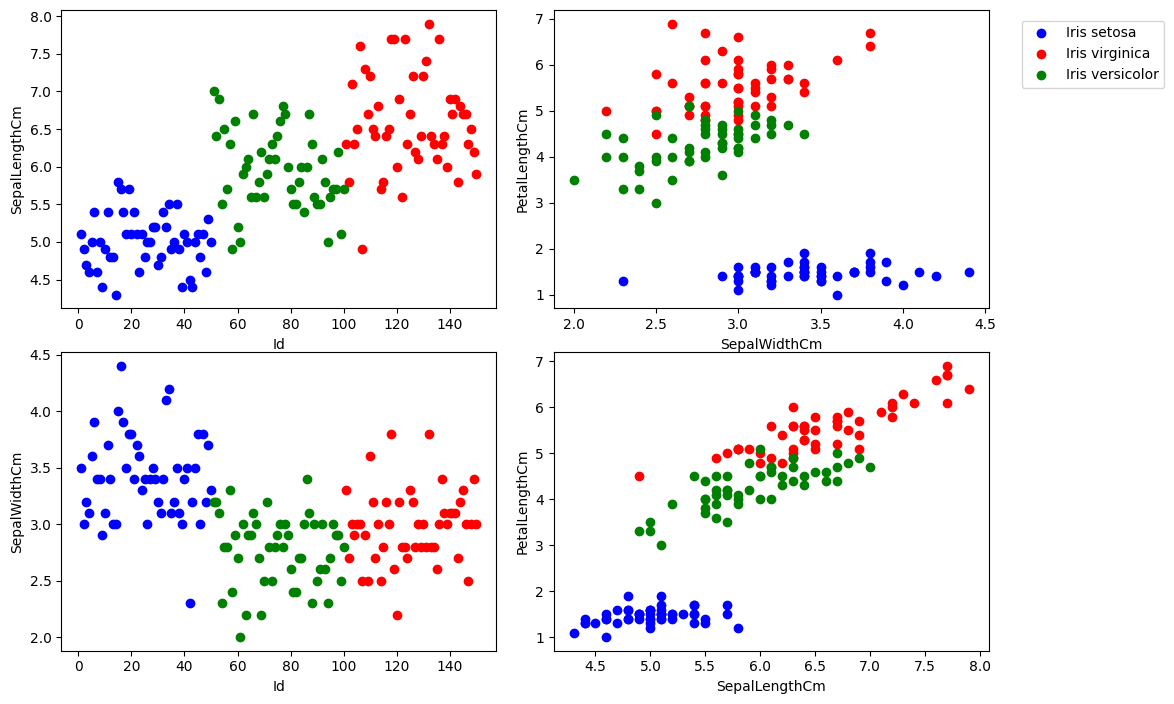

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

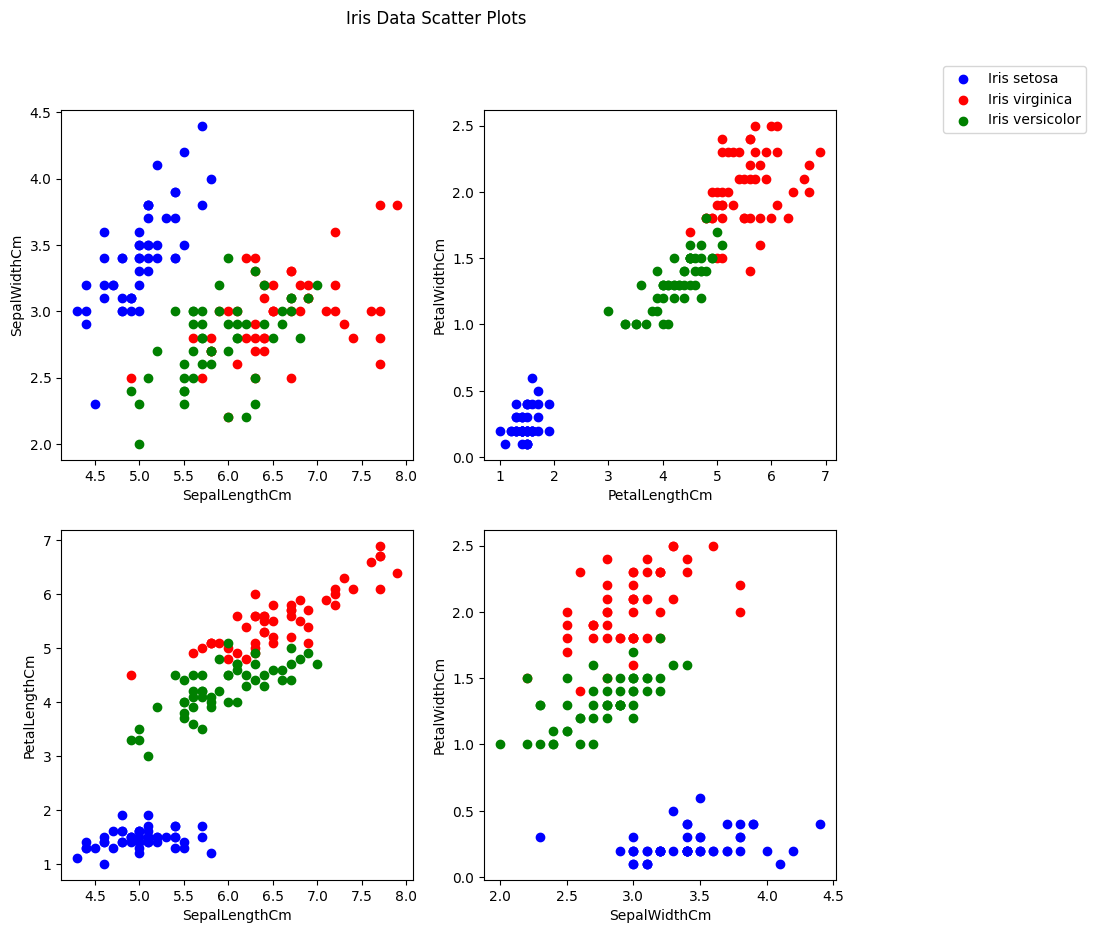

In [ ]:
#ChatGPT

def layout():
    global fig, axes
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Iris Data Scatter Plots')

layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0] + 1]  # Adjusting for 'Id' column
        y = df.columns[plots[i][1] + 1]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j], label=labels[j] if i == 0 else "")
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

## Perform Train/Test/Split

In [6]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y_train = F.one_hot(torch.LongTensor(y_train))  # not needed with Cross Entropy Loss
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Prepare DataLoader
For this analysis we don't need to create a Dataset object, but we should take advantage of PyTorch's DataLoader tool. Even though our dataset is small (120 training samples), we'll load it into our model in two batches. This technique becomes very helpful with large datasets.

Note that scikit-learn already shuffled the source dataset before preparing train and test sets. We'll still benefit from the DataLoader shuffle utility for model training if we make multiple passes throught the dataset.

In [7]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)

testloader = DataLoader(X_test, batch_size=60, shuffle=False)

## Define loss equations and optimizations
As before, we'll utilize <a href='https://en.wikipedia.org/wiki/Cross_entropy'>Cross Entropy</a> with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll use a variation of Stochastic Gradient Descent called <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (short for Adaptive Moment Estimation), with <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [8]:
# FOR REDO
torch.manual_seed(4)
model = Model()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train the model

In [10]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.09568226
epoch: 11  loss: 0.98190653
epoch: 21  loss: 0.75652307
epoch: 31  loss: 0.49447522
epoch: 41  loss: 0.34981874
epoch: 51  loss: 0.22807853
epoch: 61  loss: 0.13547322
epoch: 71  loss: 0.09162075
epoch: 81  loss: 0.07378192
epoch: 91  loss: 0.06546164


## Plot the loss function

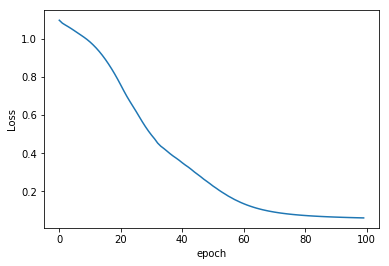

In [11]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

## Validate the model
Now we run the test set through the model to see if the loss calculation resembles the training data.

In [12]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06246195


In [13]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([-0.3355,  7.3630,  1.3783])     1
 2. tensor([0.2775, 8.1554, 0.4269])        1
 3. tensor([ 11.9969,   6.1847, -19.1976])  0
 4. tensor([-2.0187,  7.9664,  4.2447])     1
 5. tensor([-6.1348,  7.9516, 11.0913])     2
 6. tensor([-10.2635,   8.3101,  17.9998])  2
 7. tensor([ 12.0542,   6.4321, -19.2909])  0
 8. tensor([ 12.9507,   6.4819, -20.7540])  0
 9. tensor([-5.7723,  8.2435, 10.5083])     2
10. tensor([-7.8867,  8.6126, 14.0731])     2
11. tensor([-8.7055,  8.6074, 15.4337])     2
12. tensor([ 11.6358,   5.8167, -18.6220])  0
13. tensor([-8.1009,  8.2331, 14.3888])     2
14. tensor([-2.0791,  7.7752,  4.3188])     1
15. tensor([-6.0828,  8.3916, 11.0586])     2
16. tensor([0.1360, 7.8660, 0.6409])        1
17. tensor([-4.0875,  7.7217,  7.6642])     2
18. tensor([ 13.1522,   6.5911, -21.0798])  0
19. tensor([-1.5644,  8.0222,  3.4754])     1
20. tensor([-6.2859,  8.9728, 11.4248])     2
21. tensor([ 12.3859,   6.2571, -19.8275])  0
22. tensor([ 13.8200,   7.0859, -2

Here we can see that #17 was misclassified.

## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Save the model

In [14]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

### Load a new model
We'll load a new model object and test it as we had before to make sure it worked.

In [15]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [16]:
with torch.no_grad():
    y_val = new_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06246195


## Apply the model to classify new, unseen data

In [17]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

Let's plot this new iris in yellow to see where it falls in relation to the others:

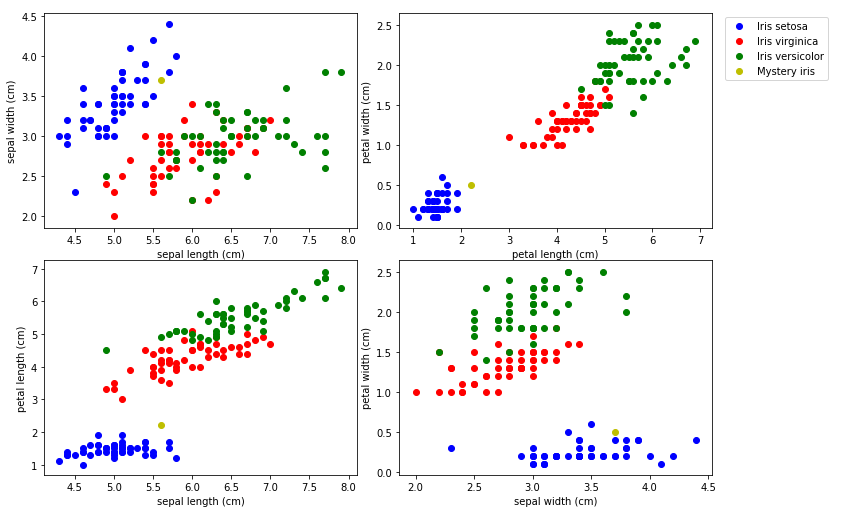

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

Now run it through the model:

In [19]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([ 12.2116,   7.1285, -19.5247])

Iris setosa


## Great job!